In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import zipfile
import os

# Path to your zip file
zip_file_path = 'Raw_time_domian_data.zip'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_dataset')  # Extracts to 'extracted_dataset' folder

# Path to the extracted directory
extracted_path = 'extracted_dataset'

In [3]:
# Column names to assign
column_names = [
    "time_acc", "acc_x", "acc_y", "acc_z",
    "time_gyro", "gyro_x", "gyro_y", "gyro_z"
]

In [5]:
import polars as pl
import os

# Path to parent directory with extracted data
parent_folder_path = 'extracted_dataset/1.Raw_time_domian_data'

# List to store DataFrames
dataframes = []

# Loop through all folders and CSVs
for activity_folder in os.listdir(parent_folder_path):
    activity_path = os.path.join(parent_folder_path, activity_folder)

    # Check if it's a directory (activity folder)
    if os.path.isdir(activity_path):
        print(f"📚 Loading data for activity: {activity_folder}")

        # Process each CSV in the activity folder
        for file in os.listdir(activity_path):
            if file.endswith('.csv'):
                file_path = os.path.join(activity_path, file)

                try:
                    # Read CSV with custom columns and streaming
                    df = pl.read_csv(file_path, has_header=False, new_columns=column_names)

                    # Add activity and file info for reference
                    df = df.with_columns([
                        pl.lit(activity_folder).alias('activity'),
                        pl.lit(file).alias('source_file')
                    ])

                    # Append DataFrame to list
                    dataframes.append(df)

                except Exception as e:
                    print(f"⚠️ Error loading {file}: {e}")

# Concatenate all DataFrames if not empty
if dataframes:
    combined_df = pl.concat(dataframes, how="vertical_relaxed", rechunk=True)
    print('✅ All CSVs loaded successfully!')
    print(combined_df.head())
else:
    print('❗ No valid CSV files found!')

📚 Loading data for activity: 15.Stair-up
📚 Loading data for activity: 0.Stand
📚 Loading data for activity: 8.Jump
📚 Loading data for activity: 6.Lay-stand
📚 Loading data for activity: 13.Walk-circle
📚 Loading data for activity: 10.Sit-up
📚 Loading data for activity: 7.Pick
📚 Loading data for activity: 16.Stair-down
📚 Loading data for activity: 4.Stand-sit
📚 Loading data for activity: 17.Table-tennis
📚 Loading data for activity: 2.Talk-sit
📚 Loading data for activity: 1.Sit
📚 Loading data for activity: 9.Push-up
📚 Loading data for activity: 5.Lay
📚 Loading data for activity: 12.Walk-backwards
📚 Loading data for activity: 14.Run
📚 Loading data for activity: 3.Talk-stand
📚 Loading data for activity: 11.Walk
✅ All CSVs loaded successfully!
shape: (5, 10)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ time_acc ┆ acc_x     ┆ acc_y     ┆ acc_z     ┆ … ┆ gyro_y    ┆ gyro_z    ┆ activity  ┆ source_fi │
│ ---      ┆ ---       ┆ ---       ┆ 

In [6]:
combined_df.shape

(6308771, 10)

In [7]:
# Remove duplicates based on all columns
combined_df = combined_df.unique()

In [8]:
combined_df.shape

(6308769, 10)

In [9]:
# Check for rows with any null values
rows_with_nulls = combined_df.filter(combined_df.select(pl.all().is_null()).sum_horizontal() > 0)
print(rows_with_nulls)

shape: (4, 10)
┌──────────┬───────────┬───────────┬───────────┬───┬────────┬────────┬──────────┬───────────────┐
│ time_acc ┆ acc_x     ┆ acc_y     ┆ acc_z     ┆ … ┆ gyro_y ┆ gyro_z ┆ activity ┆ source_file   │
│ ---      ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---    ┆ ---    ┆ ---      ┆ ---           │
│ f64      ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64    ┆ f64    ┆ str      ┆ str           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪════════╪════════╪══════════╪═══════════════╡
│ 73.476   ┆ -2.27914  ┆ -0.641479 ┆ 0.031948  ┆ … ┆ null   ┆ null   ┆ 14.Run   ┆ 1101_O_11.csv │
│ 73.499   ┆ -0.919262 ┆ -1.505156 ┆ -1.537756 ┆ … ┆ null   ┆ null   ┆ 14.Run   ┆ 1101_O_11.csv │
│ 73.499   ┆ -1.130262 ┆ -0.797156 ┆ -1.633756 ┆ … ┆ null   ┆ null   ┆ 14.Run   ┆ 1101_O_11.csv │
│ 73.499   ┆ -1.034262 ┆ -0.394156 ┆ -1.269756 ┆ … ┆ null   ┆ null   ┆ 14.Run   ┆ 1101_O_11.csv │
└──────────┴───────────┴───────────┴───────────┴───┴────────┴────────┴──────────┴───────────────┘


In [10]:
# Drop rows with any null values
clean_df = combined_df.drop_nulls()
clean_df.shape

(6308765, 10)

In [11]:
print(clean_df['activity'].unique())

shape: (18,)
Series: 'activity' [str]
[
	"16.Stair-down"
	"11.Walk"
	"4.Stand-sit"
	"6.Lay-stand"
	"0.Stand"
	…
	"7.Pick"
	"1.Sit"
	"15.Stair-up"
	"17.Table-tennis"
	"3.Talk-stand"
]


In [12]:
# Remove numbers followed by a dot
clean_df = clean_df.with_columns(
    pl.col("activity").str.replace(r"\d+\.\s*", "").alias("activity")
)


In [13]:
clean_df.shape

(6308765, 10)

In [14]:
# Count class occurrences
class_counts = clean_df.group_by("activity").agg(
    pl.col("activity").count().alias("count")
)

print(class_counts)

shape: (18, 2)
┌──────────────┬────────┐
│ activity     ┆ count  │
│ ---          ┆ ---    │
│ str          ┆ u32    │
╞══════════════╪════════╡
│ Lay          ┆ 547924 │
│ Sit          ┆ 558618 │
│ Run          ┆ 188967 │
│ Stair-up     ┆ 252820 │
│ Table-tennis ┆ 134862 │
│ …            ┆ …      │
│ Talk-sit     ┆ 538583 │
│ Walk         ┆ 266339 │
│ Push-up      ┆ 158734 │
│ Walk-circle  ┆ 78073  │
│ Lay-stand    ┆ 527370 │
└──────────────┴────────┘


In [15]:
# Drop rows where 'activity' equals 'walking'
df_filtered = clean_df.filter(clean_df["activity"] != "Table-tennis")

In [16]:
df_filtered.shape

(6173903, 10)

In [17]:
# Convert to Pandas for plotting
class_counts_pd = class_counts.to_pandas()

# Extract labels and values for plotting
labels = class_counts_pd["activity"]
counts = class_counts_pd["count"]

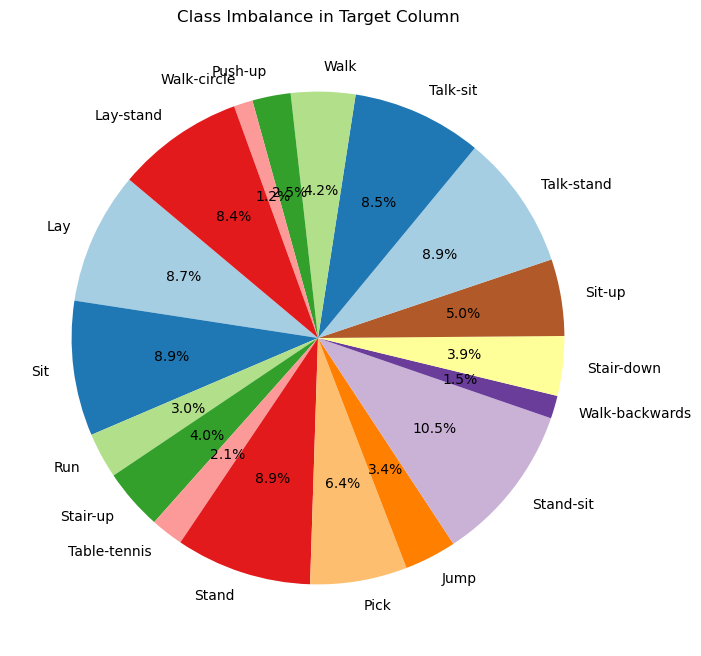

In [18]:
# Plot the class distribution as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    counts,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title("Class Imbalance in Target Column")
plt.show()

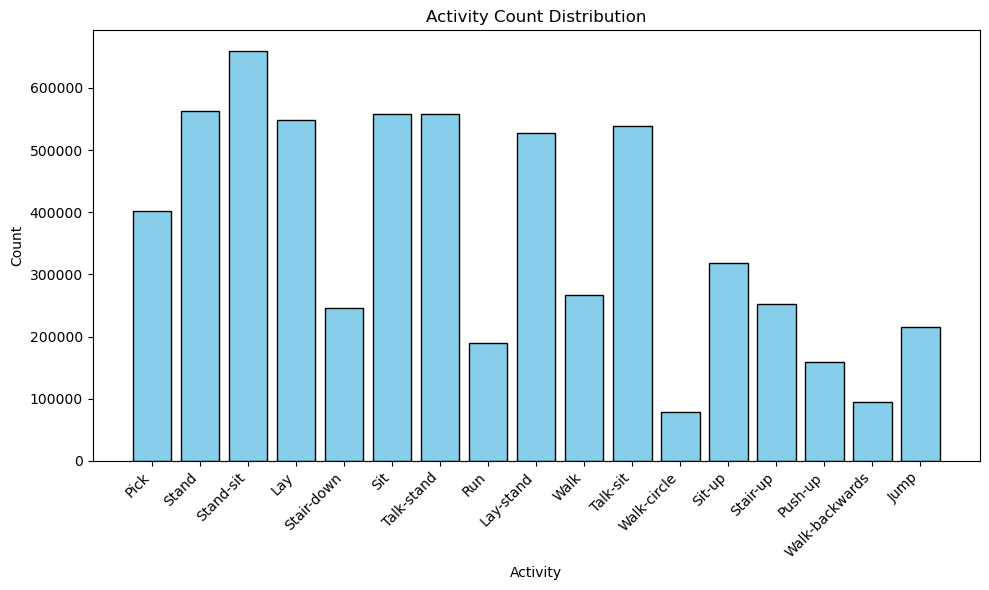

In [19]:
# Count occurrences of each activity
class_counts = df_filtered.group_by("activity").agg(
    pl.col("activity").count().alias("count")
)

# Convert to Pandas for plotting
class_counts_pd = class_counts.to_pandas()

# Extract labels and counts
labels = class_counts_pd["activity"]
counts = class_counts_pd["count"]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color="skyblue", edgecolor="black")

# Rotate and align x-axis labels
plt.xlabel("Activity")
plt.ylabel("Count")
plt.title("Activity Count Distribution")

# Rotate labels and align them to the right
plt.xticks(rotation=45, ha="right")

# Automatically adjust subplot to fit the labels
plt.tight_layout()

plt.show()

In [20]:
# Define the number of records to sample per class (e.g., minimum class size or desired number)
min_count = class_counts.select("count").min()[0, 0]
print(f"\nMinimum records per class for safe sampling: {min_count}")

# Stratified sampling with safe check to avoid errors
df_balanced = pl.concat(
    [
        df_filtered.filter(pl.col("activity") == activity)
        .sample(n=min(min_count, df_filtered.filter(pl.col("activity") == activity).height), seed=42)
        for activity in df_filtered.select("activity").unique().to_series().to_list()
    ]
)

print("\nStratified Sampled DataFrame with Class Balance:")
print(df_balanced)


Minimum records per class for safe sampling: 78073

Stratified Sampled DataFrame with Class Balance:
shape: (1_327_241, 10)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ time_acc ┆ acc_x     ┆ acc_y     ┆ acc_z     ┆ … ┆ gyro_y    ┆ gyro_z    ┆ activity  ┆ source_fi │
│ ---      ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ le        │
│ f64      ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ str       ┆ ---       │
│          ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ str       │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1.112    ┆ -0.638411 ┆ -1.872167 ┆ -3.885982 ┆ … ┆ -0.720581 ┆ -0.274979 ┆ Pick      ┆ 1039_H_1. │
│          ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ csv       │
│ 24.127   ┆ -0.020698 ┆ 0.8787172 ┆ -0.4254   ┆ … ┆ -0.907595 ┆ 0.

In [38]:


#further reducing the dataset size
# Sample 50% of the dataset
df_balanced_sampled = df_filtered.sample(fraction=0.75, seed=42)

# Check the size of the new DataFrame
print(f"Original Size: {df_balanced.shape}")
print(f"Sampled Size: {df_balanced_sampled.shape}")


Original Size: (6173903, 10)
Sampled Size: (4630427, 10)


In [21]:
#further reducing the dataset size
# Sample 50% of the dataset
df_balanced_sampled = df_balanced.sample(fraction=0.75, seed=42)

# Check the size of the new DataFrame
print(f"Original Size: {df_balanced.shape}")
print(f"Sampled Size: {df_balanced_sampled.shape}")

Original Size: (1327241, 10)
Sampled Size: (995430, 10)


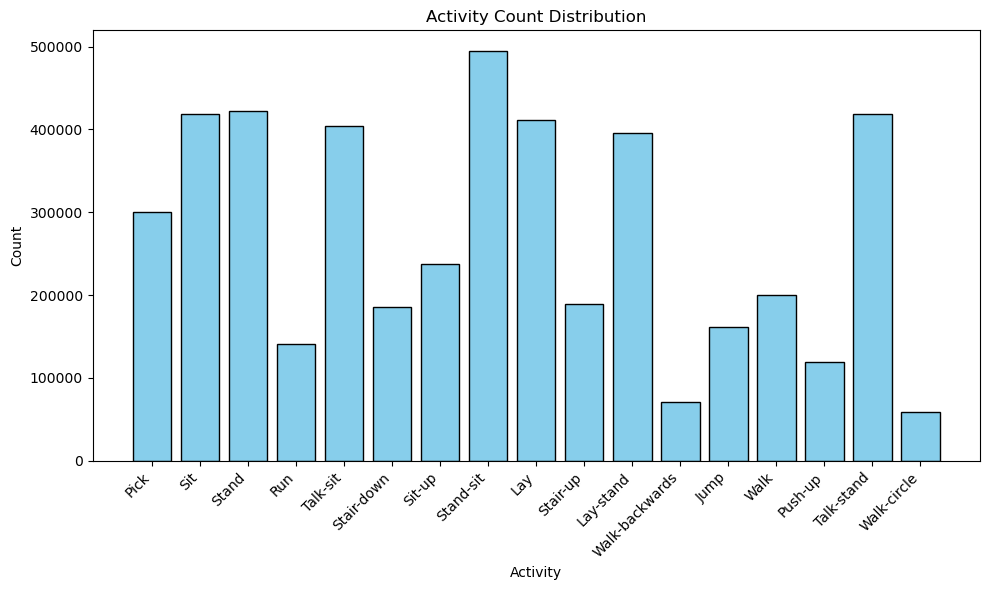

In [39]:
# Count occurrences of each activity
class_counts = df_balanced_sampled.group_by("activity").agg(
    pl.col("activity").count().alias("count")
)

# Convert to Pandas for plotting
class_counts_pd = class_counts.to_pandas()

# Extract labels and counts
labels = class_counts_pd["activity"]
counts = class_counts_pd["count"]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color="skyblue", edgecolor="black")

# Rotate and align x-axis labels
plt.xlabel("Activity")
plt.ylabel("Count")
plt.title("Activity Count Distribution")

# Rotate labels and align them to the right
plt.xticks(rotation=45, ha="right")

# Automatically adjust subplot to fit the labels
plt.tight_layout()

plt.show()

In [40]:
# Drop specific columns
columns_to_drop = ["activity", "source_file"]
df_trimmed = df_balanced_sampled.drop(columns_to_drop)
print(df_trimmed)

shape: (4_630_427, 8)
┌──────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ time_acc ┆ acc_x     ┆ acc_y     ┆ acc_z     ┆ time_gyro ┆ gyro_x    ┆ gyro_y    ┆ gyro_z    │
│ ---      ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64      ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 25.966   ┆ 0.035666  ┆ 0.002945  ┆ -0.012087 ┆ 25.946    ┆ -0.016165 ┆ 0.021628  ┆ -0.000842 │
│ 9.275    ┆ -0.008673 ┆ 0.000681  ┆ 0.06277   ┆ 9.263     ┆ -0.002833 ┆ -0.001681 ┆ -0.006215 │
│ 4.896    ┆ 0.4528396 ┆ 0.5074682 ┆ -1.744205 ┆ 4.895     ┆ 0.099912  ┆ -0.880923 ┆ -0.344976 │
│ 7.183    ┆ 0.014642  ┆ -0.029176 ┆ 0.044469  ┆ 7.182     ┆ -0.000709 ┆ 0.000379  ┆ 0.00876   │
│ 24.926   ┆ -3.378327 ┆ -0.780801 ┆ 1.0615331 ┆ 24.925    ┆ -0.366659 ┆ 1.121201  ┆ -0.241572 │
│ …     

In [41]:

# Check column names
print(df_trimmed.columns)

['time_acc', 'acc_x', 'acc_y', 'acc_z', 'time_gyro', 'gyro_x', 'gyro_y', 'gyro_z']


In [42]:
# List of columns to scale
columns_to_scale = ['time_acc', 'acc_x', 'acc_y', 'acc_z', 'time_gyro', 'gyro_x', 'gyro_y', 'gyro_z']


# Replace original columns with scaled values
# Apply Min-Max Scaling
df_scaled_replaced = df_balanced_sampled.with_columns(
    [((pl.col(col) - pl.col(col).min()) / (pl.col(col).max() - pl.col(col).min())).alias(col)
     for col in columns_to_scale]
)

print("\nDataFrame with Replaced Scaled Columns:")
print(df_scaled_replaced)


DataFrame with Replaced Scaled Columns:
shape: (4_630_427, 10)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────┬───────────────┐
│ time_acc ┆ acc_x    ┆ acc_y    ┆ acc_z    ┆ … ┆ gyro_y   ┆ gyro_z   ┆ activity   ┆ source_file   │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---        ┆ ---           │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ str        ┆ str           │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════╪═══════════════╡
│ 0.175641 ┆ 0.442197 ┆ 0.519912 ┆ 0.446018 ┆ … ┆ 0.52153  ┆ 0.518302 ┆ Lay        ┆ 1014_F_6.csv  │
│ 0.062738 ┆ 0.441848 ┆ 0.519888 ┆ 0.446704 ┆ … ┆ 0.521388 ┆ 0.518269 ┆ Stand      ┆ 1053_A_1.csv  │
│ 0.033118 ┆ 0.445485 ┆ 0.525159 ┆ 0.430154 ┆ … ┆ 0.516017 ┆ 0.516197 ┆ Pick       ┆ 1050_H_1.csv  │
│ 0.048588 ┆ 0.442032 ┆ 0.519578 ┆ 0.446536 ┆ … ┆ 0.5214   ┆ 0.51836  ┆ Sit        ┆ 1061_B_1.csv  │
│ 0.168606 ┆ 0.415289 ┆ 0.5

In [43]:
# Convert Polars DataFrame to Pandas for easier correlation
df_pandas = df_trimmed.to_pandas()

# Compute correlation matrix
correlation_matrix = df_pandas.corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
           time_acc     acc_x     acc_y     acc_z  time_gyro    gyro_x  \
time_acc   1.000000  0.000334 -0.022578  0.007573   0.999943 -0.000513   
acc_x      0.000334  1.000000 -0.056786  0.159435   0.000343  0.049543   
acc_y     -0.022578 -0.056786  1.000000 -0.013148  -0.022590 -0.045808   
acc_z      0.007573  0.159435 -0.013148  1.000000   0.007564 -0.002382   
time_gyro  0.999943  0.000343 -0.022590  0.007564   1.000000 -0.000521   
gyro_x    -0.000513  0.049543 -0.045808 -0.002382  -0.000521  1.000000   
gyro_y     0.001815 -0.059233 -0.100980  0.014492   0.001821 -0.069793   
gyro_z    -0.000066 -0.099828  0.041434 -0.031021  -0.000072 -0.635875   

             gyro_y    gyro_z  
time_acc   0.001815 -0.000066  
acc_x     -0.059233 -0.099828  
acc_y     -0.100980  0.041434  
acc_z      0.014492 -0.031021  
time_gyro  0.001821 -0.000072  
gyro_x    -0.069793 -0.635875  
gyro_y     1.000000  0.031166  
gyro_z     0.031166  1.000000  


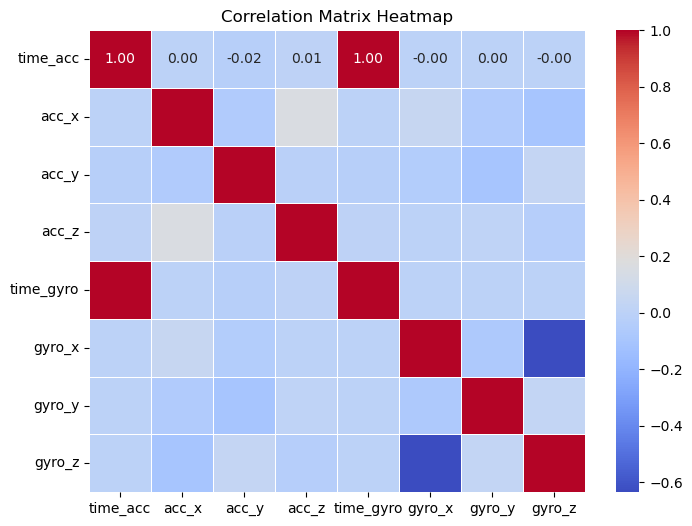

In [44]:
# Plot correlation matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [45]:
#time_gyro & time_acc are having very high corelation as can be seen from heatmap , hence we can drop any one of them for the dataset

# Compute correlation matrix
correlation_matrix = df_pandas.corr().abs()

# Define correlation threshold
correlation_threshold = 0.9

# Identify columns to drop based on high correlation
to_drop = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > correlation_threshold:
            colname = correlation_matrix.columns[j]
            to_drop.add(colname)

print(f"\nColumns to drop due to high correlation: {to_drop}")

# Drop high-correlation columns in Polars
df_scaled_cleaned = df_scaled_replaced.drop(list(to_drop))

print("\nDataFrame after dropping highly correlated columns:")
print(df_scaled_cleaned)


Columns to drop due to high correlation: {'time_gyro'}

DataFrame after dropping highly correlated columns:
shape: (4_630_427, 9)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────┬───────────────┐
│ time_acc ┆ acc_x    ┆ acc_y    ┆ acc_z    ┆ … ┆ gyro_y   ┆ gyro_z   ┆ activity   ┆ source_file   │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---        ┆ ---           │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ str        ┆ str           │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════╪═══════════════╡
│ 0.175641 ┆ 0.442197 ┆ 0.519912 ┆ 0.446018 ┆ … ┆ 0.52153  ┆ 0.518302 ┆ Lay        ┆ 1014_F_6.csv  │
│ 0.062738 ┆ 0.441848 ┆ 0.519888 ┆ 0.446704 ┆ … ┆ 0.521388 ┆ 0.518269 ┆ Stand      ┆ 1053_A_1.csv  │
│ 0.033118 ┆ 0.445485 ┆ 0.525159 ┆ 0.430154 ┆ … ┆ 0.516017 ┆ 0.516197 ┆ Pick       ┆ 1050_H_1.csv  │
│ 0.048588 ┆ 0.442032 ┆ 0.519578 ┆ 0.446536 ┆ … ┆ 0.5214   ┆ 

In [46]:
df_scaled_cleaned=df_scaled_cleaned.drop('source_file')

In [47]:
df_scaled_cleaned.head()

time_acc,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,activity
f64,f64,f64,f64,f64,f64,f64,str
0.175641,0.442197,0.519912,0.446018,0.542253,0.52153,0.518302,"""Lay"""
0.062738,0.441848,0.519888,0.446704,0.542316,0.521388,0.518269,"""Stand"""
0.033118,0.445485,0.525159,0.430154,0.542801,0.516017,0.516197,"""Pick"""
0.048588,0.442032,0.519578,0.446536,0.542326,0.5214,0.51836,"""Sit"""
0.168606,0.415289,0.511761,0.455852,0.5406,0.528247,0.51683,"""Stair-down"""


In [48]:
# Split features and target
X = df_scaled_cleaned.select(pl.exclude("activity")).to_numpy()  # Select all columns except "label"
y = df_scaled_cleaned["activity"].to_numpy()  # Target/label column



In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [50]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42,stratify=y
)

print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")

Shape of X_train: (3241298, 7), Shape of y_train: (3241298,)
Shape of X_test: (1389129, 7), Shape of y_test: (1389129,)


In [90]:
# Create and train the Random Forest model
randomforestmodel = RandomForestClassifier(n_estimators=100, random_state=42)
randomforestmodel.fit(X_train, y_train)

print("Random Forest Model Trained Successfully!")

Random Forest Model Trained Successfully!


In [91]:
# Make predictions
y_pred = randomforestmodel.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f" Random Forest Model Accuracy: {accuracy:.2f}")
print("\n Random Forest Model Classification Report:")
print(classification_report(y_test, y_pred))

 Random Forest Model Accuracy: 0.56

 Random Forest Model Classification Report:
                precision    recall  f1-score   support

          Jump       0.71      0.60      0.65      4720
           Lay       0.66      0.57      0.61      4711
     Lay-stand       0.56      0.45      0.50      4636
          Pick       0.40      0.32      0.36      4688
       Push-up       0.54      0.64      0.59      4668
           Run       0.78      0.78      0.78      4718
           Sit       0.57      0.70      0.63      4698
        Sit-up       0.62      0.56      0.59      4623
    Stair-down       0.56      0.43      0.48      4689
      Stair-up       0.50      0.42      0.45      4682
         Stand       0.56      0.55      0.56      4709
     Stand-sit       0.51      0.62      0.56      4690
      Talk-sit       0.61      0.64      0.62      4668
    Talk-stand       0.62      0.65      0.63      4652
          Walk       0.48      0.60      0.53      4660
Walk-backwards       0

In [95]:
#!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.2 MB/s eta 0:00:0000:0100:01


In [51]:
from sklearn.preprocessing import LabelEncoder
# Encode target labels (Convert categorical to numeric)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [52]:
# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [55]:
import xgboost as xgb

# Create DMatrix for XGBoost (efficient training format)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': len(set(y)),  # Number of classes
    'eval_metric': 'mlogloss',  # Log loss for multiclass classification
    'max_depth': 6,  # Maximum depth of a tree
    'eta': 0.05,  # Learning rate
    'gamma': 0.1,  # Minimum loss reduction required for split
}

# Train the XGBoost model
num_rounds = 500  # Number of boosting rounds
xgbmodel = xgb.train(params, dtrain, num_boost_round=num_rounds)
print("XGBoost Model Trained Successfully!")



XGBoost Model Trained Successfully!


In [56]:
# Make predictions
y_pred = xgbmodel.predict(dtest)

# Evaluate model 
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

XGBoost Model Accuracy: 0.5847

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.60      0.66     48545
           1       0.68      0.57      0.62    123270
           2       0.57      0.49      0.53    118685
           3       0.42      0.34      0.37     90251
           4       0.57      0.44      0.49     35662
           5       0.80      0.75      0.78     42397
           6       0.57      0.75      0.65    125701
           7       0.65      0.44      0.52     71447
           8       0.56      0.42      0.48     55541
           9       0.49      0.36      0.42     56836
          10       0.58      0.58      0.58    126668
          11       0.56      0.79      0.66    148447
          12       0.65      0.62      0.63    121191
          13       0.64      0.75      0.69    125618
          14       0.45      0.68      0.54     59999
          15       0.37      0.11      0.17     21328
          16       0.40  